In [3]:
import sys
sys.path.append('../src')

import pickle
import matplotlib.pyplot as plt
import geopandas as gpd
from iecdt.data import geom
import geoplot as gplt
import numpy as np
from glob import glob
import pandas as pd
from joblib import Parallel, delayed
world = geom.get_world()
from IPython.display import Markdown
from iecdt.genai import mistral



## read all text embeddings

In [4]:
files = glob('/opt/data/dora/embeddings/consolidated/*')
def readf(fname):
    with open(fname, 'rb') as f:
        z = pickle.load(f)
        
    return {k: z[k] for k in ['chip_id', 'text_embedding', 'lonlat']}

embs = Parallel(verbose=5, n_jobs=-1)(delayed(readf)(fname) for fname in files)
embs = pd.DataFrame(embs)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 512 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 8160 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 45384 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 48313 out of 48313 | elapsed:    2.3s finished


## create an array with all vectors for searching

In [5]:
vdb = np.r_[[np.r_[i] for i in embs.text_embedding.values]]
vdb.shape

(48313, 1024)

In [6]:
embs.head()

,chip_id,text_embedding,lonlat
0,00217e53ae025,"[-0.020782470703125, 0.037078857421875, 0.0402...","(23.528842211411103, 15.450666195202487)"
1,305c4716ab785,"[-0.0316162109375, 0.048004150390625, 0.043823...","(54.821557935421026, 62.755649953351664)"
2,0ac172540e823,"[-0.0265655517578125, 0.032684326171875, 0.049...","(85.53991161186431, 26.485483925845262)"
3,087a4afcebe35,"[-0.019805908203125, 0.04046630859375, 0.05792...","(147.8775275593774, 64.562401914625)"
4,1bacb25ff4da4,"[-0.02130126953125, 0.048919677734375, 0.04275...","(0.8942767029818856, 15.970550853338139)"


## make a query and use mistral to get the embeddings

In [7]:
m = mistral.MistralEmbeddingsAPIModel(api_key='../../secrets/mistral.txt')

model mistral-embed configure for API calls


In [64]:
q = 'rivers through cities'
q = 'rivers'
q = 'rivers in south america'
q = 'where do camels live?'
q = 'show me beaches near by mountains'
q = 'show me beaches near by cities'
q = 'show me places with large crop fields'
q = 'show me places with circular crop fields'

qe = m.generate_embeddings_for_text(q)['api']

## get the top 20 most similar

In [65]:
distances = np.sum((vdb - qe)**2, axis=1)
top20_idxs = np.argsort(distances)[:20]

In [66]:
top20 = embs.iloc[top20_idxs].copy()
top20['distance'] = distances[top20_idxs]
top20

,chip_id,text_embedding,lonlat,distance
3203,053fa8d0a28bf,"[-0.0151824951171875, 0.0406494140625, 0.04156...","(28.29821207564381, 22.22667696749085)",0.548234
11526,13b2f58778266,"[-0.0072021484375, 0.050201416015625, 0.040191...","(-46.00212453333459, -13.803082759864845)",0.550107
33589,111c34c5be536,"[-0.0116729736328125, 0.043975830078125, 0.040...","(28.199265807061757, 22.27368488022062)",0.553500
7603,29b1224173a07,"[-0.005939483642578125, 0.043487548828125, 0.0...","(-102.77407745075016, 34.321657094526884)",0.561814
43185,1220136e09b45,"[-0.007717132568359375, 0.0535888671875, 0.039...","(-45.47822309298418, -12.323156979991817)",0.563494
42146,1d487019a9b64,"[-0.017181396484375, 0.046630859375, 0.0323181...","(120.466604300973, 43.52864046376274)",0.565776
9817,1824e1d31f9e6,"[-0.007030487060546875, 0.04339599609375, 0.04...","(-103.26897181360418, 34.606649427082196)",0.569901
13610,1ed656f6778af,"[-0.01605224609375, 0.0452880859375, 0.0376281...","(28.300786989929232, 22.504134717061227)",0.572811
15720,03ea0348fe7d2,"[-0.01363372802734375, 0.03985595703125, 0.042...","(28.15071619217789, 22.412781248650987)",0.574195
12447,149a7eb367dd8,"[-0.006694793701171875, 0.0443115234375, 0.047...","(28.84509836933375, 22.26763116638243)",0.574214


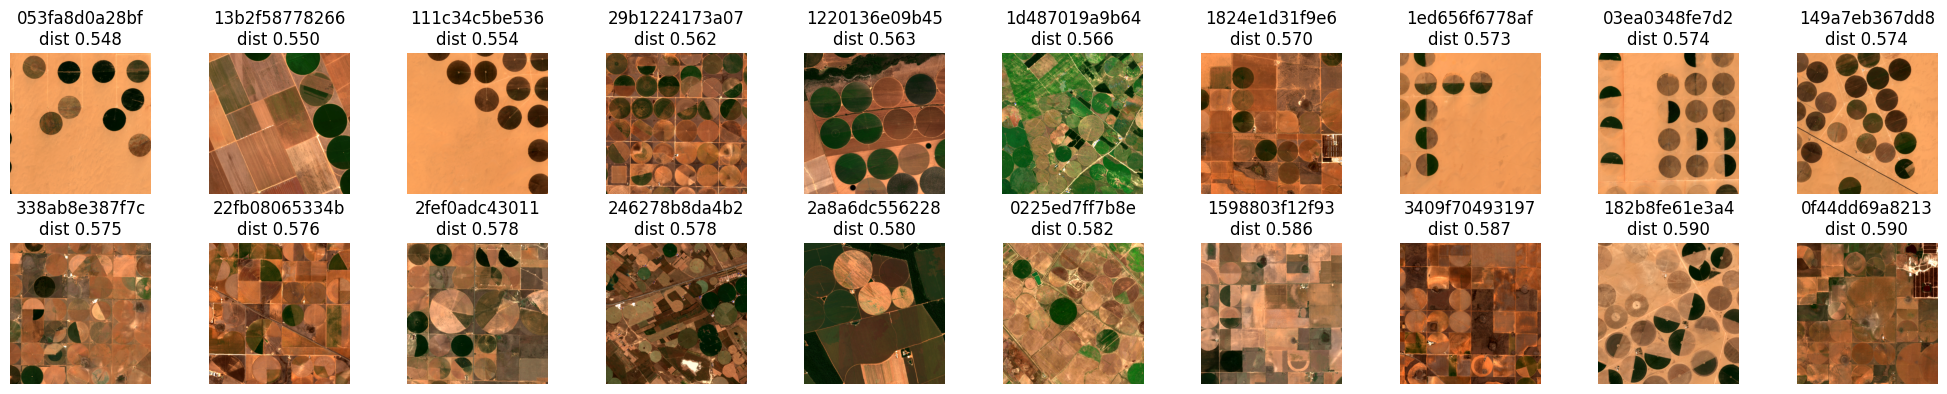

In [67]:
fig = plt.figure(figsize=(20,4))
axs = fig.subplots(2,10).flatten()

for i, (_, ti) in enumerate(top20.iterrows()):
    file = files[ti.name]
    ax = axs[i]

    # sanity check, chip id must be the same as file if
    assert file.split('/')[-1].split('.')[0] == ti.chip_id

    with open(file, 'rb') as f:
        z = pickle.load(f)    

    ax.imshow(z['img'])
    ax.set_axis_off()

    ax.set_title(f'{ti.chip_id}\ndist {ti.distance:0.3f}')
    
fig.tight_layout()

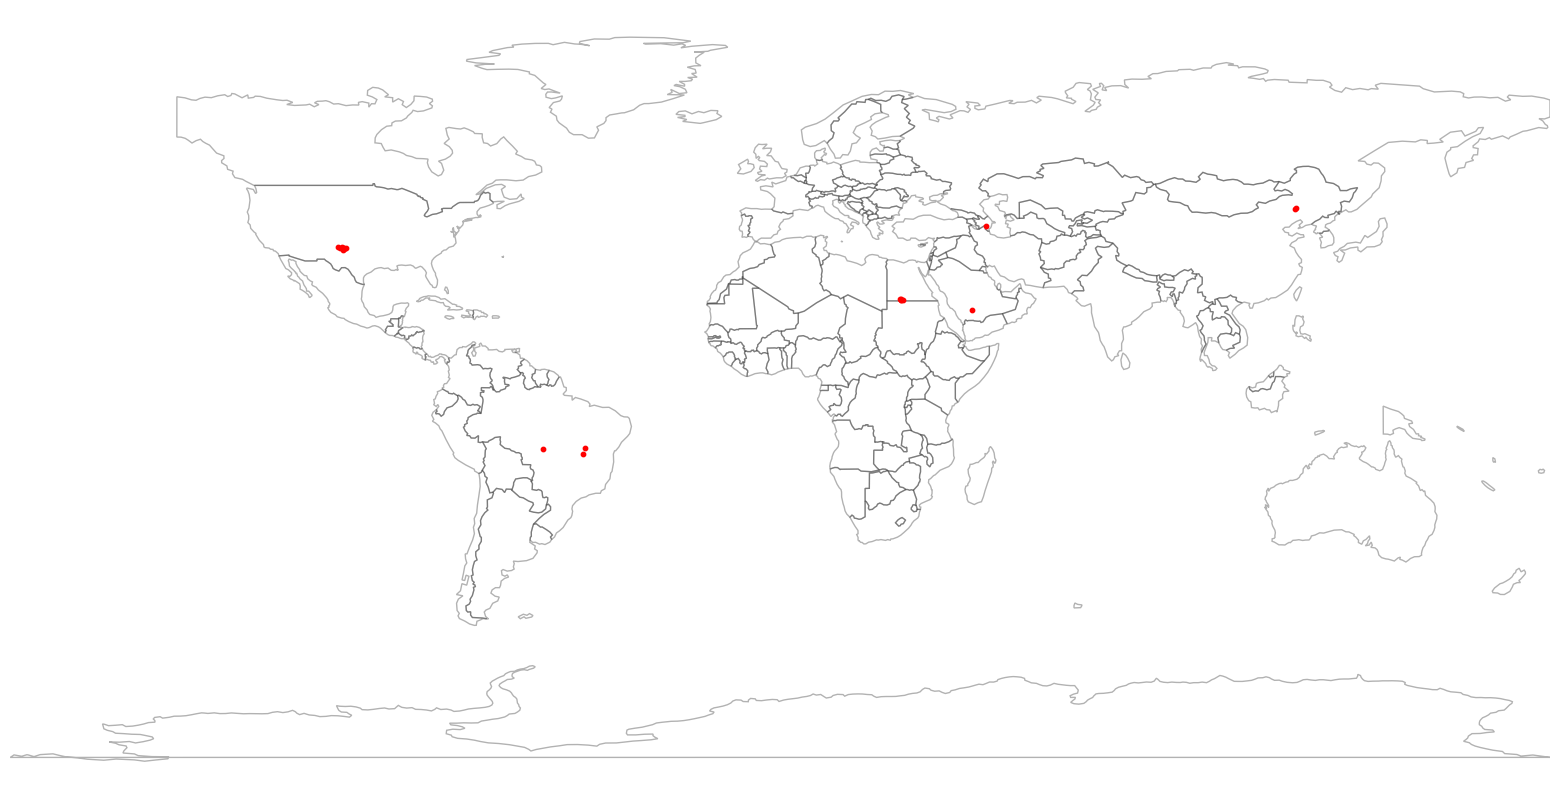

In [68]:
lonlats = np.r_[[np.r_[i] for i in top20.lonlat.values]]

ax = plt.figure(figsize=(20,10)).subplots(1,1)
gplt.polyplot(world, alpha=0.3,  ax=ax)
plt.scatter(lonlats[:,0], lonlats[:,1], color='red', alpha=1, s=10)